In [1]:
!pip install tslearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 kB 6.5 MB/s eta 0:00:00a 0:00:01


In [3]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# from tsfresh import extract_features, extract_relevant_features, select_features
# from tsfresh.utilities.dataframe_functions import impute
# from tsfresh.feature_extraction import settings

from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
import numpy
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

# seed = 0
# numpy.random.seed(seed)
# X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
# X_train = X_train[y_train < 4]  # Keep first 3 classes
# numpy.random.shuffle(X_train)
# # Keep only 50 time series
# X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train[:50])
# # Make time series shorter
# X_train = TimeSeriesResampler(sz=40).fit_transform(X_train)
# sz = X_train.shape[1]

# # Euclidean k-means
# print("Euclidean k-means")
# # km = TimeSeriesKMeans(n_clusters=3, verbose=True, random_state=seed)
# # y_pred = km.fit_predict(X_train)


## Реализуем метрику из задачи

In [5]:
def metric(true, pred, coef=1000):
    assert len(true) == len(pred)
    error = 0
    for i in range(len(true)):
        if true[i] > pred[i]:
            error += true[i] - pred[i]
        else:
            error += (pred[i] - true[i]) * coef
    return -round(error / len(true) / 1_000_000_000)

## Прочитаем и подготовим данные

In [207]:
df_train = pd.read_csv('/kaggle/input/tochka/hackaton-tochka-2023/data/train.csv')
df_train = df_train.drop(['id'], axis=1)

In [208]:
# for i in range(4):
#     plt.plot(np.arange(90), km.cluster_centers_[i].ravel())
#     plt.legend()
# plt.show()

In [209]:
print(df_train.shape)
df_train.head()

(20000, 90)


,day 1,day 2,day 3,day 4,day 5,day 6,day 7,day 8,day 9,day 10,...,day 81,day 82,day 83,day 84,day 85,day 86,day 87,day 88,day 89,day 90
0,569369144437,152818843344,-15490421929,-406624212,800362695678,2306966308406,1917859437929,1075925676467,277630770065,-1039738738,...,-23536698564,1524999469315,1668473296482,-55911238122,1105906678699,1134120612066,-26829699967,-19492512239,1850461161279,-1781621104800
1,-104722473995,-29275417695,423353969042,416864670779,-323866168258,-59323097843,58355171506,250838843414,-184607036341,371352008249,...,529867756317,-245569015020,-13050008306,1122739774405,-358972410001,-294465761456,289760186052,588830896355,-21661542192,-153747680862
2,-42697753432,154940888256,5290701628,2915610080,-241412656598,-2172755647,-60115526657,99210264232,281086593365,64728036374,...,32773187167,-347787851371,172520154368,46099833867,-297776587790,200380940252,153279754373,42773997259,5607112117,4789271560371
3,735945593435,877636042341,-5241075542,-1817826687,1008399822616,996548931508,471592893006,479393037398,246618026800,-5322931641,...,4227540489,855279732927,808871471815,-8997018250,627399608353,223093070252,-25844611162,-9955925825,603978495789,366344015281
4,697850269572,980815916948,-11470196952,-21103754202,1207799272628,1202816134496,559646086486,1058635690664,122661998719,3419722951,...,-17229675906,940502608045,728437869463,13477840270,1455297859610,409612399843,-6730004331,19193466540,1163355637082,-138405088616


In [210]:
df_train.head()

,day 1,day 2,day 3,day 4,day 5,day 6,day 7,day 8,day 9,day 10,...,day 81,day 82,day 83,day 84,day 85,day 86,day 87,day 88,day 89,day 90
0,569369144437,152818843344,-15490421929,-406624212,800362695678,2306966308406,1917859437929,1075925676467,277630770065,-1039738738,...,-23536698564,1524999469315,1668473296482,-55911238122,1105906678699,1134120612066,-26829699967,-19492512239,1850461161279,-1781621104800
1,-104722473995,-29275417695,423353969042,416864670779,-323866168258,-59323097843,58355171506,250838843414,-184607036341,371352008249,...,529867756317,-245569015020,-13050008306,1122739774405,-358972410001,-294465761456,289760186052,588830896355,-21661542192,-153747680862
2,-42697753432,154940888256,5290701628,2915610080,-241412656598,-2172755647,-60115526657,99210264232,281086593365,64728036374,...,32773187167,-347787851371,172520154368,46099833867,-297776587790,200380940252,153279754373,42773997259,5607112117,4789271560371
3,735945593435,877636042341,-5241075542,-1817826687,1008399822616,996548931508,471592893006,479393037398,246618026800,-5322931641,...,4227540489,855279732927,808871471815,-8997018250,627399608353,223093070252,-25844611162,-9955925825,603978495789,366344015281
4,697850269572,980815916948,-11470196952,-21103754202,1207799272628,1202816134496,559646086486,1058635690664,122661998719,3419722951,...,-17229675906,940502608045,728437869463,13477840270,1455297859610,409612399843,-6730004331,19193466540,1163355637082,-138405088616


IndexError: index 10 is out of bounds for axis 0 with size 10

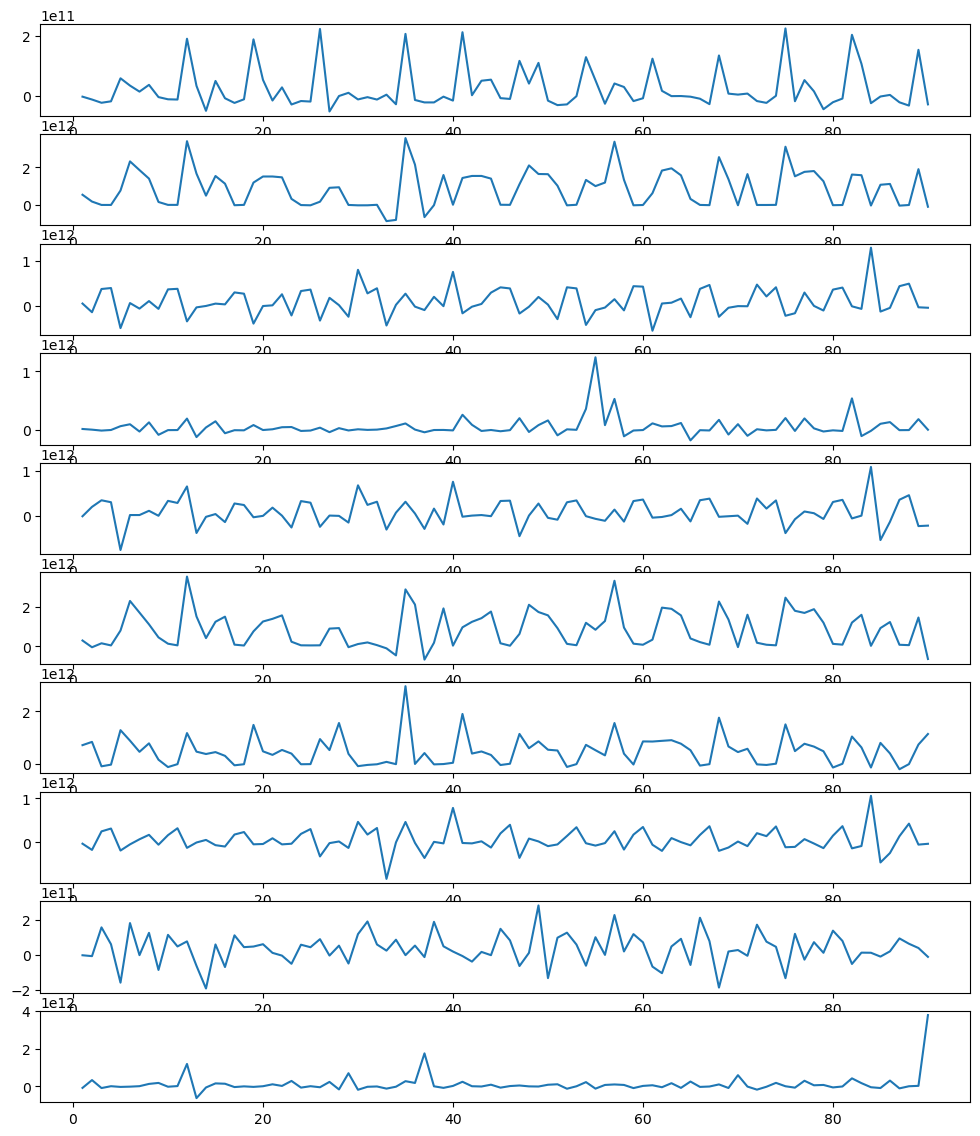

<Figure size 640x480 with 0 Axes>

<Figure size 3500x1400 with 0 Axes>

<Figure size 3500x1400 with 0 Axes>

<Figure size 3500x1400 with 0 Axes>

<Figure size 3500x1400 with 0 Axes>

<Figure size 3500x1400 with 0 Axes>

<Figure size 3500x1400 with 0 Axes>

<Figure size 3500x1400 with 0 Axes>

<Figure size 3500x1400 with 0 Axes>

<Figure size 3500x1400 with 0 Axes>

<Figure size 3500x1400 with 0 Axes>

<Figure size 3500x1400 with 0 Axes>

In [211]:
from matplotlib.pyplot import figure

plt.rcParams['figure.figsize'] = [12, 14]

f, axis = plt.subplots(10, 1)
figure(figsize=(8, 6), dpi=80)
X = df_train[[f'day {x}' for x in range(1, 91)]]
plot_x = np.arange(1, 91)
for i in range(20, 31):
    plot_y = X.iloc[i]
    plt.figure().set_figwidth(35)
    axis[i-20].plot(plot_x, np.array(X.iloc[i]))
# axis[0].plot(plot_x, plot_y1)
# axis[1].plot(plot_x, plot_y2)
# axis[2].plot(plot_x, plot_y3)
# axis[3].plot(plot_x, plot_y4)


In [212]:
dates = np.array('2020-01-01', dtype=np.datetime64) + np.arange(90)

In [213]:
temp_T = df_train.T
temp_T.index = dates

In [214]:
X = df_train[[f'day {x}' for x in range(1, 90)]]
# X = TimeSeriesScalerMeanVariance().fit_transform(X)

Y = df_train['day 90']
# X = data_temp[:, :90]
# Y = data_temp[:, 90]

In [215]:
raw_scaled = TimeSeriesScalerMeanVariance().fit_transform([df_train])
for i in range(1, 90):
    X[f'day {i}'] = raw_scaled[:, :, i-1][0]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# **MAKE NN EMBEDDINGS**

In [217]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [218]:
class SequenceDataset(Dataset):

  def __init__(self, X, Y, len_ts=X.shape[0]):
    self.X = X
    self.Y = Y

  def __getitem__(self, idx):
    return torch.Tensor(self.X.iloc[idx]), torch.Tensor([self.Y.iloc[idx]])
  
  def __len__(self):
    return len(self.X)

In [221]:
BATCH_SIZE = 128 # Training batch size
split = 0.8 # Train/Test Split ratio
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
train_ds, test_ds = SequenceDataset(X_train, Y_train), SequenceDataset(X_test, Y_test)

# Split the data according to our split ratio and load each subset into a
# separate DataLoader object
trainloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
testloader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [238]:
class LSTMForecaster(nn.Module):


  def __init__(self, n_features, n_hidden, n_outputs, sequence_len, n_lstm_layers=1, n_deep_layers=10, use_cuda=True, dropout=0.2):
    '''
    n_features: number of input features (1 for univariate forecasting)
    n_hidden: number of neurons in each hidden layer
    n_outputs: number of outputs to predict for each training example
    n_deep_layers: number of hidden dense layers after the lstm layer
    sequence_len: number of steps to look back at for prediction
    dropout: float (0 < dropout < 1) dropout ratio between dense layers
    '''
    super().__init__()

    self.n_lstm_layers = n_lstm_layers
    self.nhid = n_hidden
    self.use_cuda = use_cuda # set option for device selection

    # LSTM Layer
    self.lstm = nn.LSTM(n_features,
                        n_hidden,
                        num_layers=n_lstm_layers,
                        batch_first=True) # As we have transformed our data in this way
    
    # first dense after lstm
    self.fc1 = nn.Linear(n_hidden * sequence_len, n_hidden) 
    # Dropout layer 
    self.dropout = nn.Dropout(p=dropout)

    # Create fully connected layers (n_hidden x n_deep_layers)
    dnn_layers = []
    for i in range(n_deep_layers):
      # Last layer (n_hidden x n_outputs)
      if i == n_deep_layers - 1:
        dnn_layers.append(nn.ReLU())
        dnn_layers.append(nn.Linear(nhid, n_outputs))
      # All other layers (n_hidden x n_hidden) with dropout option
      else:
        dnn_layers.append(nn.ReLU())
        dnn_layers.append(nn.Linear(nhid, nhid))
        if dropout:
          dnn_layers.append(nn.Dropout(p=dropout))
    # compile DNN layers
    self.dnn = nn.Sequential(*dnn_layers)

  def forward(self, x):

    # Initialize hidden state
    hidden_state = torch.zeros(self.n_lstm_layers, x.shape[0], self.nhid)
    cell_state = torch.zeros(self.n_lstm_layers, x.shape[0], self.nhid)
    # move hidden state to device
    
    if self.use_cuda:
      hidden_state = hidden_state.to(device)
      cell_state = cell_state.to(device)
        
    self.hidden = (hidden_state, cell_state)

    # Forward Pass
    x = x.unsqueeze(-1)
    x, h = self.lstm(x, self.hidden) # LSTM
    x_1 = self.dropout(x.contiguous().view(x.shape[0], -1)) # Flatten lstm out 
    x_2 = self.fc1(x_1) # First Dense
    return self.dnn(x_2), x # Pass forward through fully connected DNN.

In [239]:
nhid = 64 # Number of nodes in the hidden layer
n_dnn_layers = 5 # Number of hidden fully connected layers
nout = 1 # Prediction Window
sequence_len = 89 # Training Window
device = 'cuda' if torch.cuda.is_available() else 'cpu'
USE_CUDA = True if torch.cuda.is_available() else False

# Number of features (since this is a univariate timeseries we'll set
# this to 1 -- multivariate analysis is coming in the future)
ninp = 1

# Initialize the model
model = LSTMForecaster(ninp, nhid, nout, sequence_len, n_deep_layers=n_dnn_layers, use_cuda=USE_CUDA).to(device)


In [240]:
lr = 1e-3
n_epochs = 50
# Initialize the loss function and optimizer

criterion = nn.L1Loss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [241]:
y

tensor([ 1.0709e+11, -1.0255e+11,  3.3475e+12, -6.4870e+11, -1.0760e+12,
        -1.7689e+12, -2.6922e+10,  1.7546e+11,  6.8764e+11,  7.5196e+11,
         3.9059e+12, -1.1324e+09, -1.6231e+11,  3.4574e+10,  6.5043e+11,
        -2.8179e+10, -2.7385e+11, -2.0487e+11, -5.6503e+10, -1.9773e+12,
        -1.9975e+12, -7.7407e+10,  4.9673e+11,  1.4680e+11,  3.5903e+12,
        -3.4355e+11,  5.2552e+10, -9.2606e+10, -4.3832e+11, -2.0448e+10,
         7.6262e+11, -5.1630e+10,  2.0985e+11,  7.1324e+11, -1.2586e+11,
        -6.9710e+11, -2.0551e+12,  2.6760e+11, -5.8956e+10, -8.0525e+11,
        -2.2427e+12,  4.0802e+12,  4.4528e+11,  3.7351e+10, -3.9087e+09,
        -1.3776e+10,  4.7076e+12, -9.3402e+10,  6.2427e+11, -3.1452e+10,
        -8.4023e+09, -1.6421e+11,  1.7960e+12,  4.1497e+12,  7.3418e+11,
        -1.6476e+12, -3.9739e+09, -5.5235e+09, -1.7335e+12, -2.9759e+12,
        -6.1546e+10,  3.8491e+11,  7.0988e+11, -5.5923e+10,  3.4651e+12,
         4.0990e+11,  8.9283e+11, -6.3097e+10,  3.5

In [242]:
# Lists to store training and validation losses
t_losses, v_losses = [], []
# Loop over epochs
for epoch in range(n_epochs):
  train_loss, valid_loss = 0.0, 0.0
  # train step
  model.train()
  # Loop over train dataset
  for x, y in trainloader:
    optimizer.zero_grad()
    # move inputs to device
    x = x.to(device)
    y  = y.squeeze().to(device)
    # Forward Pass
    preds = model(x)[0].squeeze()
    loss = criterion(preds, y) # compute batch loss
    train_loss += loss.item()
    loss.backward()
    optimizer.step()
  epoch_loss = train_loss / len(trainloader)
  t_losses.append(epoch_loss)
  
#   validation step
  model.eval()
  # Loop over validation dataset
  for x, y in testloader:
    with torch.no_grad():
      x, y = x.to(device), y.squeeze().to(device)
      preds = model(x)[0].squeeze()
      error = criterion(preds, y)
    valid_loss += error.item()
  valid_loss = valid_loss / len(testloader)
  v_losses.append(valid_loss)
      
  print(f'{epoch} - train: {epoch_loss}, valid: {valid_loss}')

0 - train: 1086502632161.28, valid: 1111309259941.1614
1 - train: 1086495751929.856, valid: 1110786117764.1292
2 - train: 1086177892368.384, valid: 1106011240910.4517
3 - train: 1082538438164.48, valid: 1096060580236.3871
4 - train: 1068649070723.072, valid: 1082442264972.3871
5 - train: 1036983867015.168, valid: 1085401154064.5161
6 - train: 1024726629613.568, valid: 1037238696926.9678
7 - train: 1001536558727.168, valid: 1012330114411.3549
8 - train: 966469231312.896, valid: 963690808881.5483
9 - train: 926487219798.016, valid: 919878028915.6129
10 - train: 889319371309.056, valid: 946159093826.0646
11 - train: 884964259266.56, valid: 853826687636.6451
12 - train: 828974251900.928, valid: 780574865870.4517
13 - train: 777214316249.088, valid: 727436543537.5483
14 - train: 730063402696.704, valid: 683685175031.742
15 - train: 683739146354.688, valid: 617639173879.742
16 - train: 598632366866.432, valid: 495453908331.35486
17 - train: 498745223938.048, valid: 460142918094.4516
18 - tra

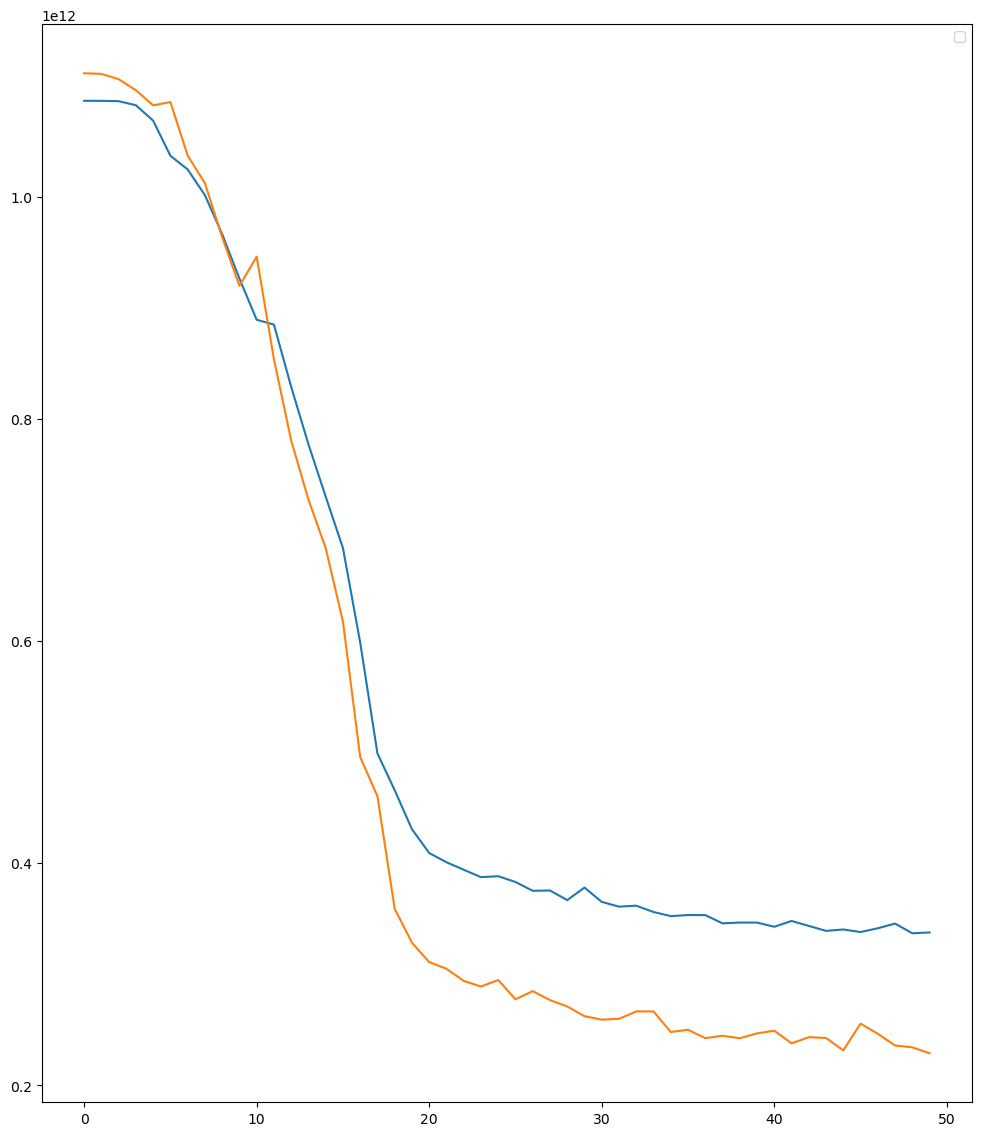

In [243]:
plt.plot(np.arange(50), t_losses)
plt.plot(np.arange(50), v_losses)
plt.legend()
plt.show()

In [11]:
X

,day 1,day 2,day 3,day 4,day 5,day 6,day 7,day 8,day 9,day 10,...,day 80,day 81,day 82,day 83,day 84,day 85,day 86,day 87,day 88,day 89
0,569369144437,152818843344,-15490421929,-406624212,800362695678,2306966308406,1917859437929,1075925676467,277630770065,-1039738738,...,-19148904713,-23536698564,1524999469315,1668473296482,-55911238122,1105906678699,1134120612066,-26829699967,-19492512239,1850461161279
1,-104722473995,-29275417695,423353969042,416864670779,-323866168258,-59323097843,58355171506,250838843414,-184607036341,371352008249,...,330976588040,529867756317,-245569015020,-13050008306,1122739774405,-358972410001,-294465761456,289760186052,588830896355,-21661542192
2,-42697753432,154940888256,5290701628,2915610080,-241412656598,-2172755647,-60115526657,99210264232,281086593365,64728036374,...,169669285257,32773187167,-347787851371,172520154368,46099833867,-297776587790,200380940252,153279754373,42773997259,5607112117
3,735945593435,877636042341,-5241075542,-1817826687,1008399822616,996548931508,471592893006,479393037398,246618026800,-5322931641,...,-25780592418,4227540489,855279732927,808871471815,-8997018250,627399608353,223093070252,-25844611162,-9955925825,603978495789
4,697850269572,980815916948,-11470196952,-21103754202,1207799272628,1202816134496,559646086486,1058635690664,122661998719,3419722951,...,23074058185,-17229675906,940502608045,728437869463,13477840270,1455297859610,409612399843,-6730004331,19193466540,1163355637082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,-24628787635,267495848867,-12230119509,-679136157,-187955674883,4597158234,-2418401538,9854043544,-14559914953,-1289364359,...,-10817404355,-7158916464,204729538824,-39577541831,-18068542326,105241442152,-59936288497,-26435699898,-1400118718,250752357103
19996,23385081422,-15228303151,-8918281087,-7772984843,-7543131908,123891713099,-81767137062,62477678253,44174672734,-12150043765,...,-5647287323,-7626731747,157231720804,79682589968,-26953658290,53427137426,59564486558,-20909395485,-15970211056,223711674873
19997,-17572384426,215467299511,-9758708941,-3626522770,-182333216840,70907176369,-16418782963,-1289752268,299779480157,32189978840,...,71302288525,-17792945695,-336100103876,266432384316,-36450926686,-7151728550,185309970484,59247462995,-17951159898,-66380991478
19998,-34373226151,-123943635780,2186315945,1323094644,44423732764,67484356011,-29553565822,66448231612,-3151812187,11711526851,...,62576050464,29253821343,186004596897,-38862536845,49943281842,-70544749716,106782921385,51233576000,43731331086,-3692332109


In [12]:
raw_scaled[:, :, 0].shape

NameError: name 'raw_scaled' is not defined

In [13]:
raw_scaled = TimeSeriesScalerMeanVariance().fit_transform([X])
for i in range(1, 90):
    X[f'day {i}'] = raw_scaled[:, :, i-1][0]


NameError: name 'TimeSeriesScalerMeanVariance' is not defined

In [125]:
dates = np.array('2020-01-01', dtype=np.datetime64) + np.arange(89)
X_T = X.T
X_T.index = dates
X_T.head()

,0,1,2,3,4,5,6,7,8,9,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
2020-01-01,0.940454,-0.917788,-0.746807,1.399649,1.294633,-0.708154,-0.646532,-0.665714,-0.453038,-0.772748,...,0.405119,-0.642962,-0.758902,-0.818788,-0.732664,-0.696997,-0.564639,-0.677545,-0.723859,-0.693108
2020-01-02,-0.206870,-0.650102,-0.201705,1.557392,1.808540,-0.672092,-0.600696,0.115762,-0.817343,-0.683504,...,-0.598313,-0.604693,-0.147611,0.245399,-0.797471,0.072263,-0.615910,-0.054379,-0.880532,-0.781318
2020-01-03,-0.637074,2.125138,-0.506272,-0.572562,-0.611770,-0.637260,-0.560436,-0.555086,-0.639947,-0.993734,...,0.472465,-0.710459,1.542602,-0.695334,-0.516680,-0.616553,-0.595707,-0.600997,-0.525812,-0.648407
2020-01-04,-0.501803,2.384193,-0.478825,-0.511563,-0.644952,-0.607228,-0.702637,-0.599180,-0.621062,-0.539208,...,-0.118298,-0.696982,1.970086,-0.565682,-0.527100,-0.503688,-0.552751,-0.524073,-0.489840,-0.642191
2020-01-05,0.835248,-1.037024,-0.899707,1.181709,1.513785,-0.293697,0.097035,-0.647045,-0.490988,-0.148035,...,1.409469,-0.330849,-0.604427,-0.507971,-0.335997,-0.810681,-0.510225,-0.801317,-0.423680,-0.402631


In [244]:
season_df = pd.DataFrame(index=[f'seasonal_{i}' for i in range(1, 90)]).T
trend_df = pd.DataFrame(index=[f'trend_{i}' for i in range(1, 90)]).T
residual_df = pd.DataFrame(index=[f'residual_{i}' for i in range(1, 90)]).T
for i in range(20000):
    decomposition = seasonal_decompose(X_T[i])
    trend    = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    season_df.loc[len(season_df)] = list(seasonal.values)
    trend_df.loc[len(trend_df)] = list(trend.values)
    residual.loc[len(residual_df)] = list(residual.values)

In [245]:
from tqdm import tqdm_notebook
rnn_features_train = []
rnn_features_test = []

for ts_tensor in tqdm_notebook(train_ds):
    _, lstm_f = model(ts_tensor[0].unsqueeze(0).to(device))
    lstm_f = lstm_f[:, -1].squeeze()
    rnn_features_train.append(lstm_f.cpu().detach().numpy())
    
for ts_tensor in tqdm_notebook(test_ds):
    _, lstm_f = model(ts_tensor[0].unsqueeze(0).to(device))
    lstm_f = lstm_f[:, -1].squeeze()
    rnn_features_test.append(lstm_f.cpu().detach().numpy())
    
rnn_features_train = np.array(rnn_features_train)
rnn_features_test = np.array(rnn_features_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/16000 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/4000 [00:00<?, ?it/s]

In [149]:
rnn_features[:, 0].shape

(16000,)

In [151]:
rnn_df = pd.DataFrame()
for i in range(1, 51):
    rnn_df[f'{i}_f'] = rnn_features[:, i-1] 

In [136]:
settings_minimal = settings.MinimalFCParameters()
settings_time = settings.TimeBasedFCParameters()
settings_time.update(settings_minimal)
settings_time

NameError: name 'settings' is not defined

In [22]:
df_ts = pd.DataFrame()
for i, ts in enumerate(X.values):
    data = [[x, i] for x in ts]
    df_ts = df_ts.append(data, ignore_index=True)
df_ts.columns = ['value', 'id']
X_features = extract_features(df_ts, column_id='id', impute_function=impute, default_fc_parameters=settings_time)
X_features.head()

Feature Extraction: 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


,value__sum_values,value__median,value__mean,value__length,value__standard_deviation,value__variance,value__root_mean_square,value__maximum,value__absolute_maximum,value__minimum
0,8.369895e+13,9.580095e+11,9.404377e+11,89.0,1.029561e+12,1.059996e+24,6.429244e+08,4.687264e+12,4.687264e+12,-9.974990e+11
1,9.115872e+12,-5.705387e+08,1.024255e+11,89.0,3.293646e+11,1.084810e+23,2.139787e+08,1.338280e+12,1.338280e+12,-8.706211e+11
2,7.359919e+12,1.015733e+10,8.269572e+10,89.0,3.227082e+11,1.041406e+23,6.590961e+08,2.141046e+12,2.141046e+12,-6.641656e+11
3,3.931702e+13,4.227319e+11,4.417642e+11,89.0,5.116289e+11,2.617642e+23,7.724256e+08,3.394395e+12,3.394395e+12,-3.339520e+10
4,5.186253e+13,5.596461e+11,5.827251e+11,89.0,6.163877e+11,3.799338e+23,2.040323e+08,2.731414e+12,2.731414e+12,-1.736056e+11


In [23]:
X_new = pd.concat([X, X_features], axis=1)
X_new.head()

,day 1,day 2,day 3,day 4,day 5,day 6,day 7,day 8,day 9,day 10,...,value__sum_values,value__median,value__mean,value__length,value__standard_deviation,value__variance,value__root_mean_square,value__maximum,value__absolute_maximum,value__minimum
0,569369144437,152818843344,-15490421929,-406624212,800362695678,2306966308406,1917859437929,1075925676467,277630770065,-1039738738,...,8.369895e+13,9.580095e+11,9.404377e+11,89.0,1.029561e+12,1.059996e+24,6.429244e+08,4.687264e+12,4.687264e+12,-9.974990e+11
1,-104722473995,-29275417695,423353969042,416864670779,-323866168258,-59323097843,58355171506,250838843414,-184607036341,371352008249,...,9.115872e+12,-5.705387e+08,1.024255e+11,89.0,3.293646e+11,1.084810e+23,2.139787e+08,1.338280e+12,1.338280e+12,-8.706211e+11
2,-42697753432,154940888256,5290701628,2915610080,-241412656598,-2172755647,-60115526657,99210264232,281086593365,64728036374,...,7.359919e+12,1.015733e+10,8.269572e+10,89.0,3.227082e+11,1.041406e+23,6.590961e+08,2.141046e+12,2.141046e+12,-6.641656e+11
3,735945593435,877636042341,-5241075542,-1817826687,1008399822616,996548931508,471592893006,479393037398,246618026800,-5322931641,...,3.931702e+13,4.227319e+11,4.417642e+11,89.0,5.116289e+11,2.617642e+23,7.724256e+08,3.394395e+12,3.394395e+12,-3.339520e+10
4,697850269572,980815916948,-11470196952,-21103754202,1207799272628,1202816134496,559646086486,1058635690664,122661998719,3419722951,...,5.186253e+13,5.596461e+11,5.827251e+11,89.0,6.163877e+11,3.799338e+23,2.040323e+08,2.731414e+12,2.731414e+12,-1.736056e+11


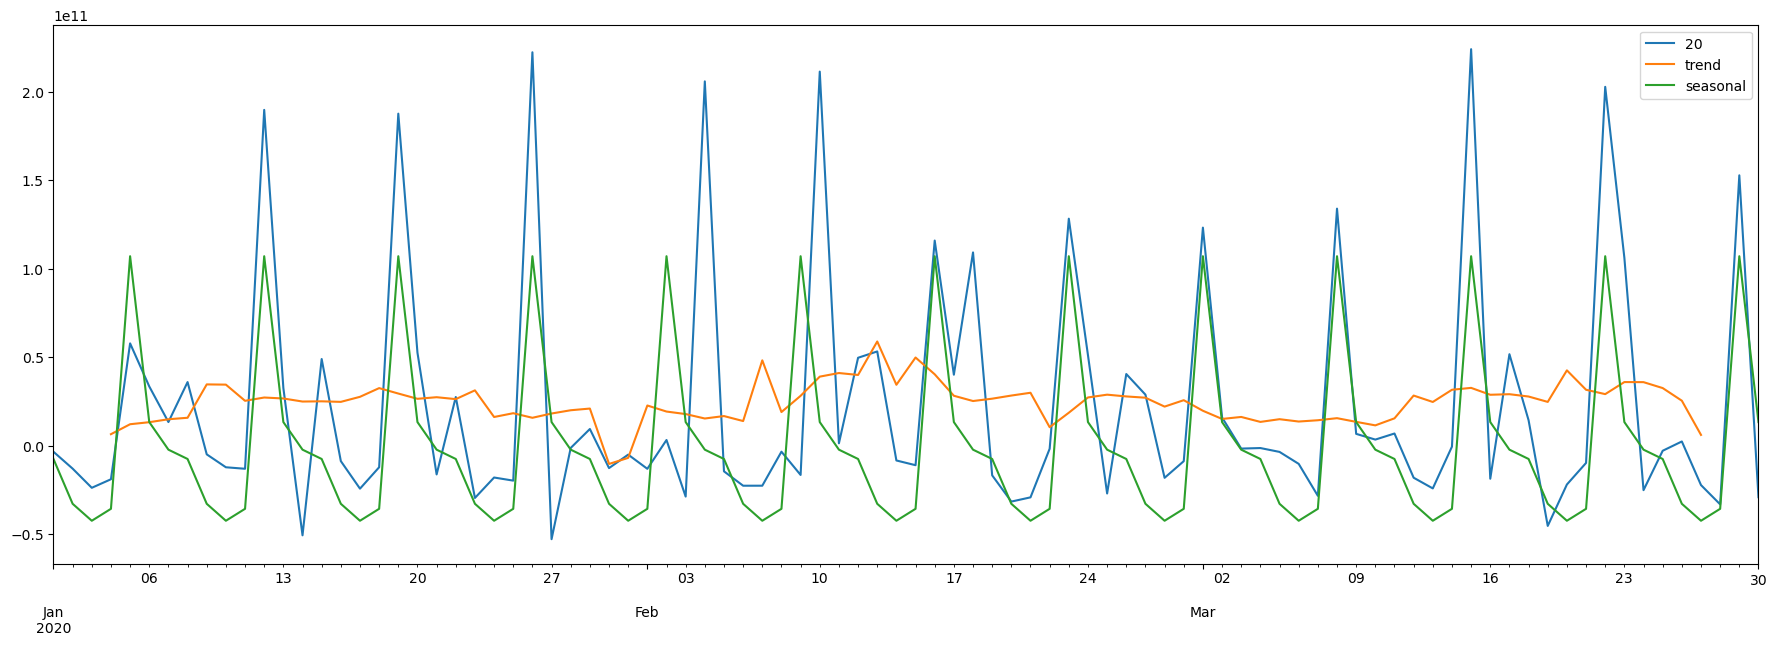

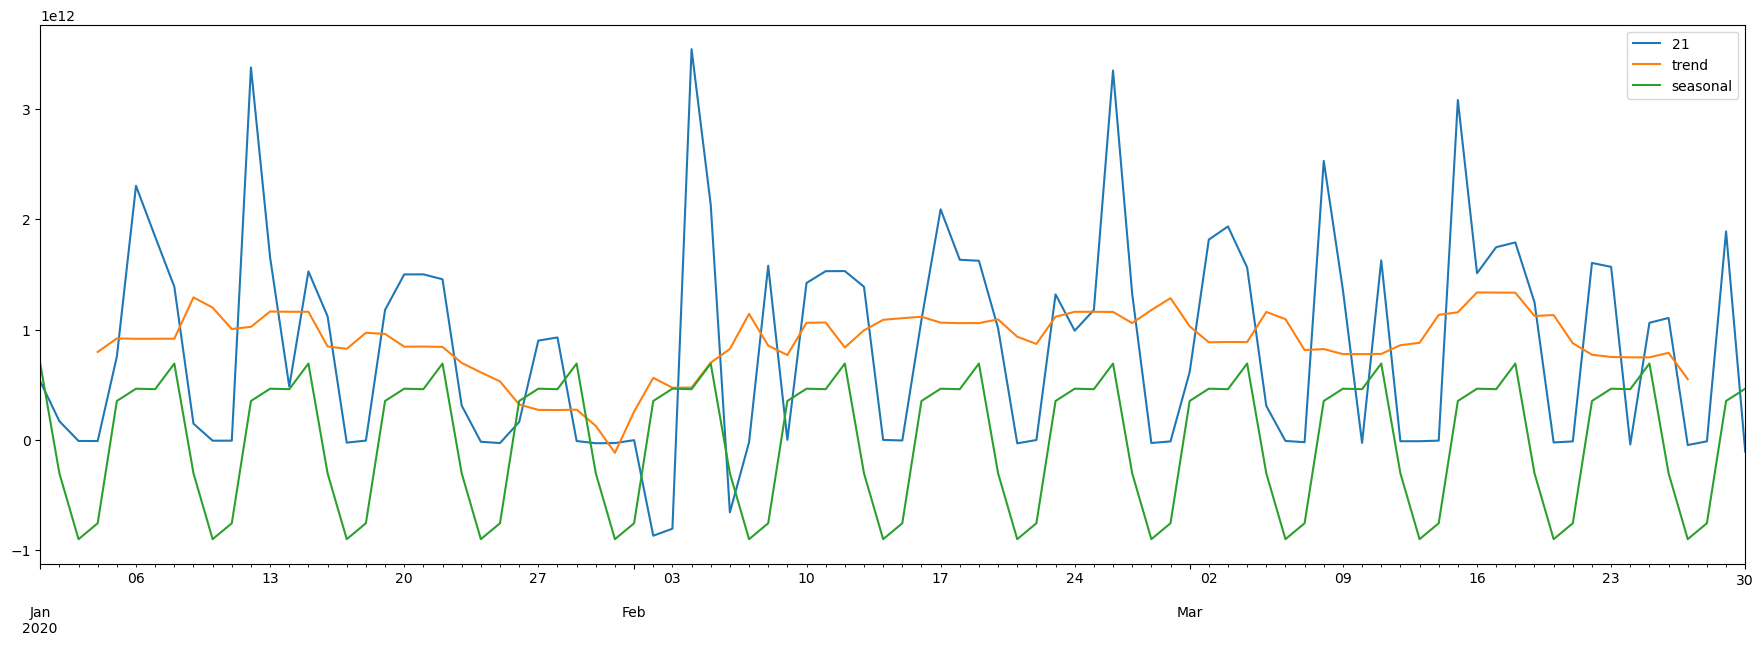

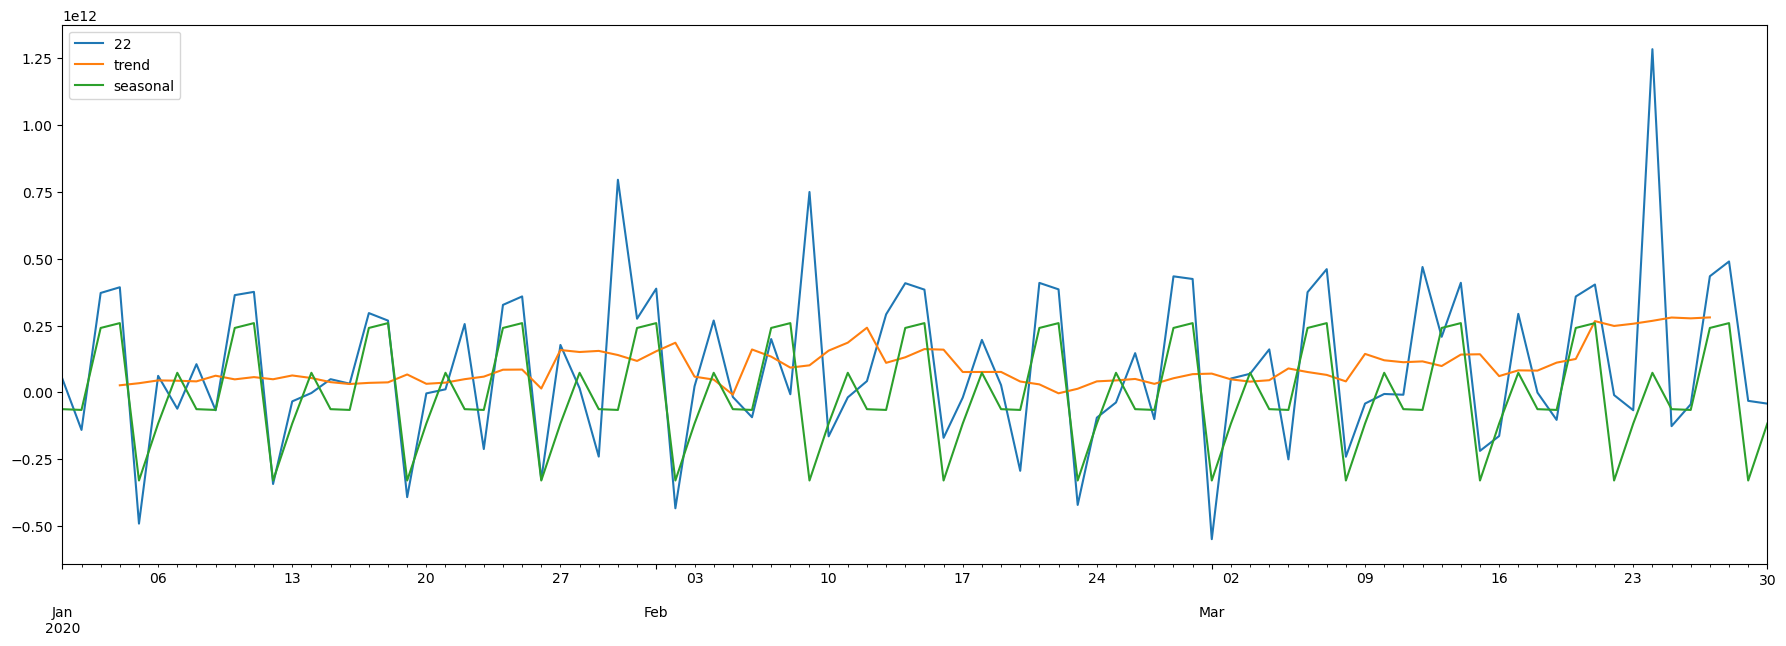

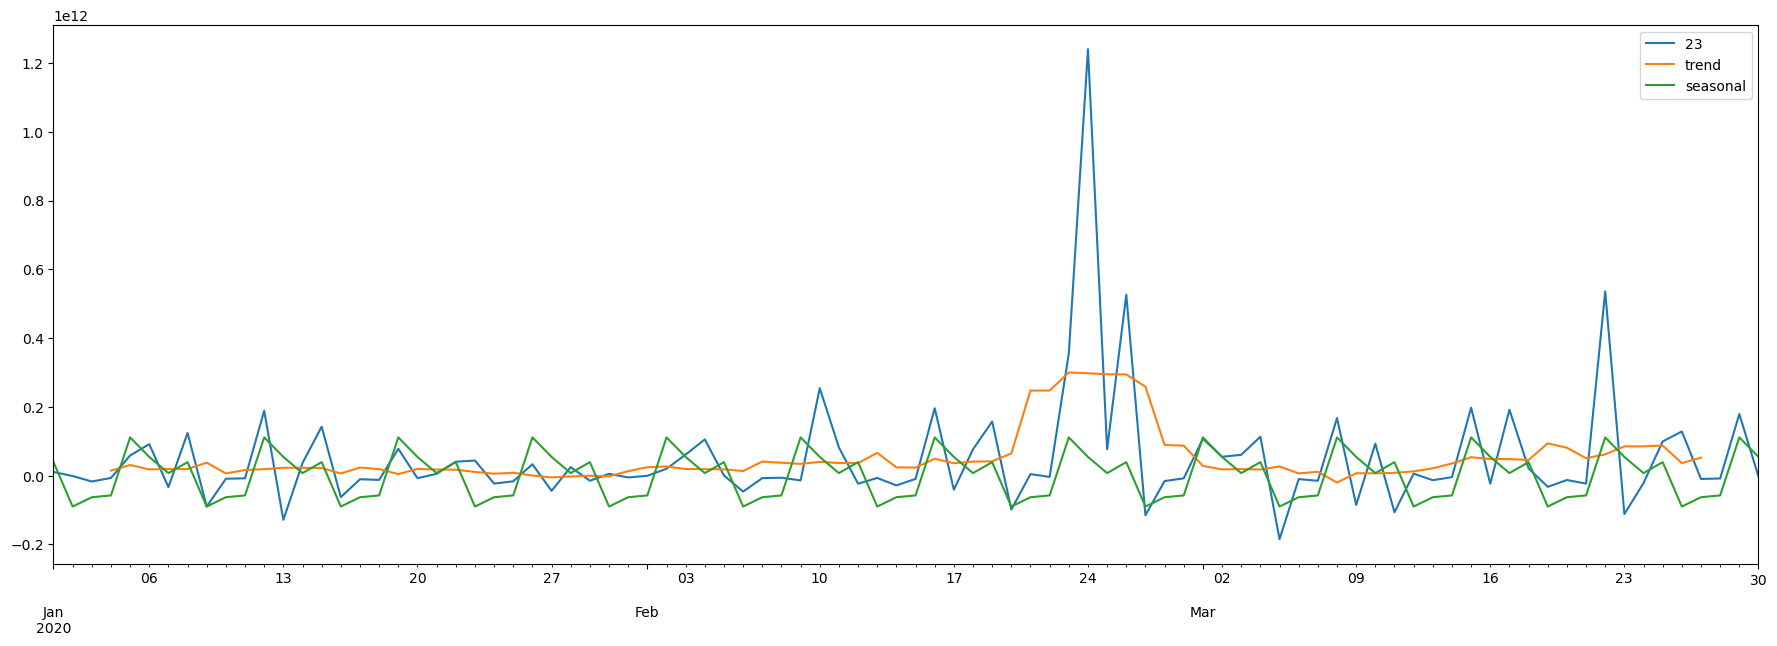

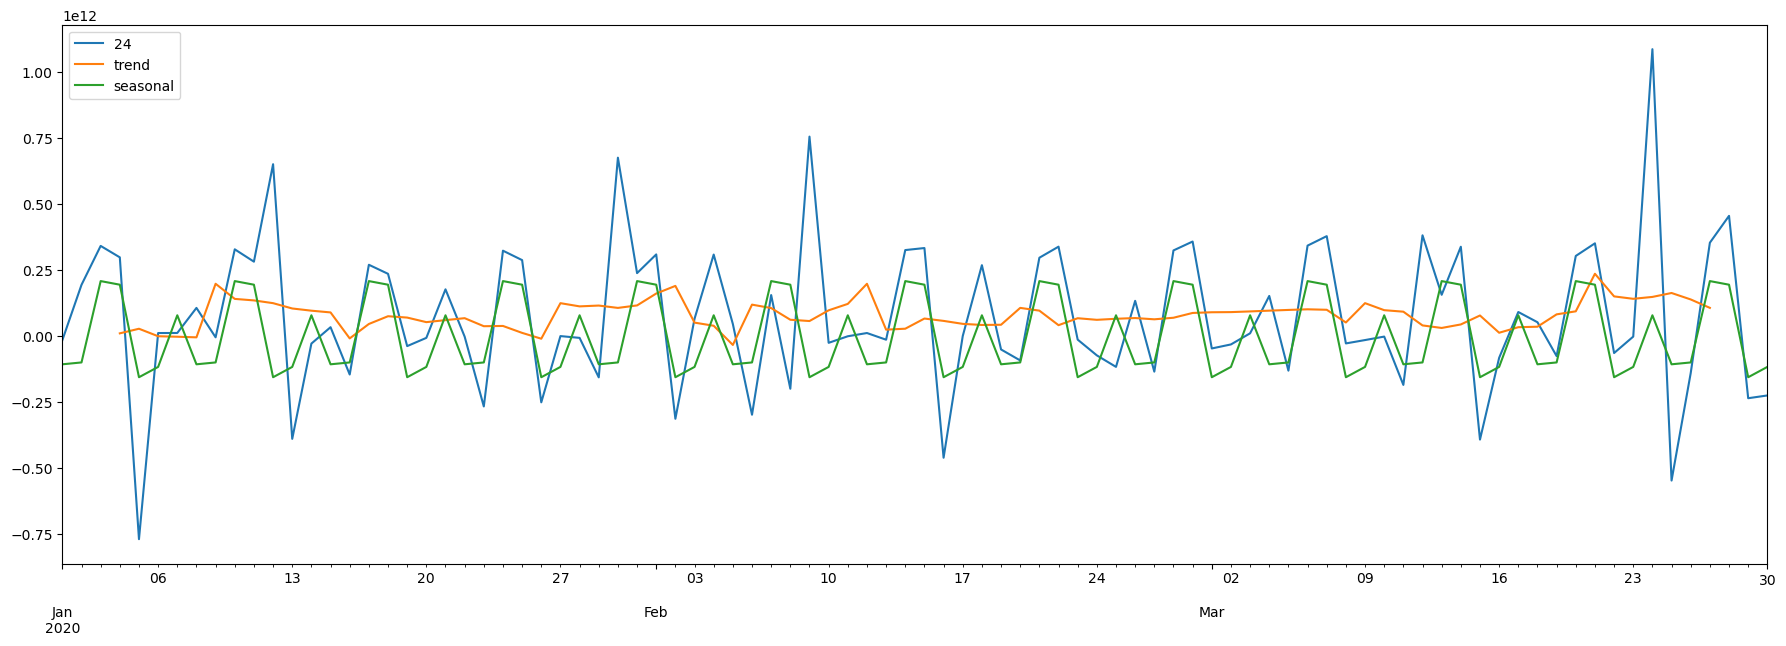

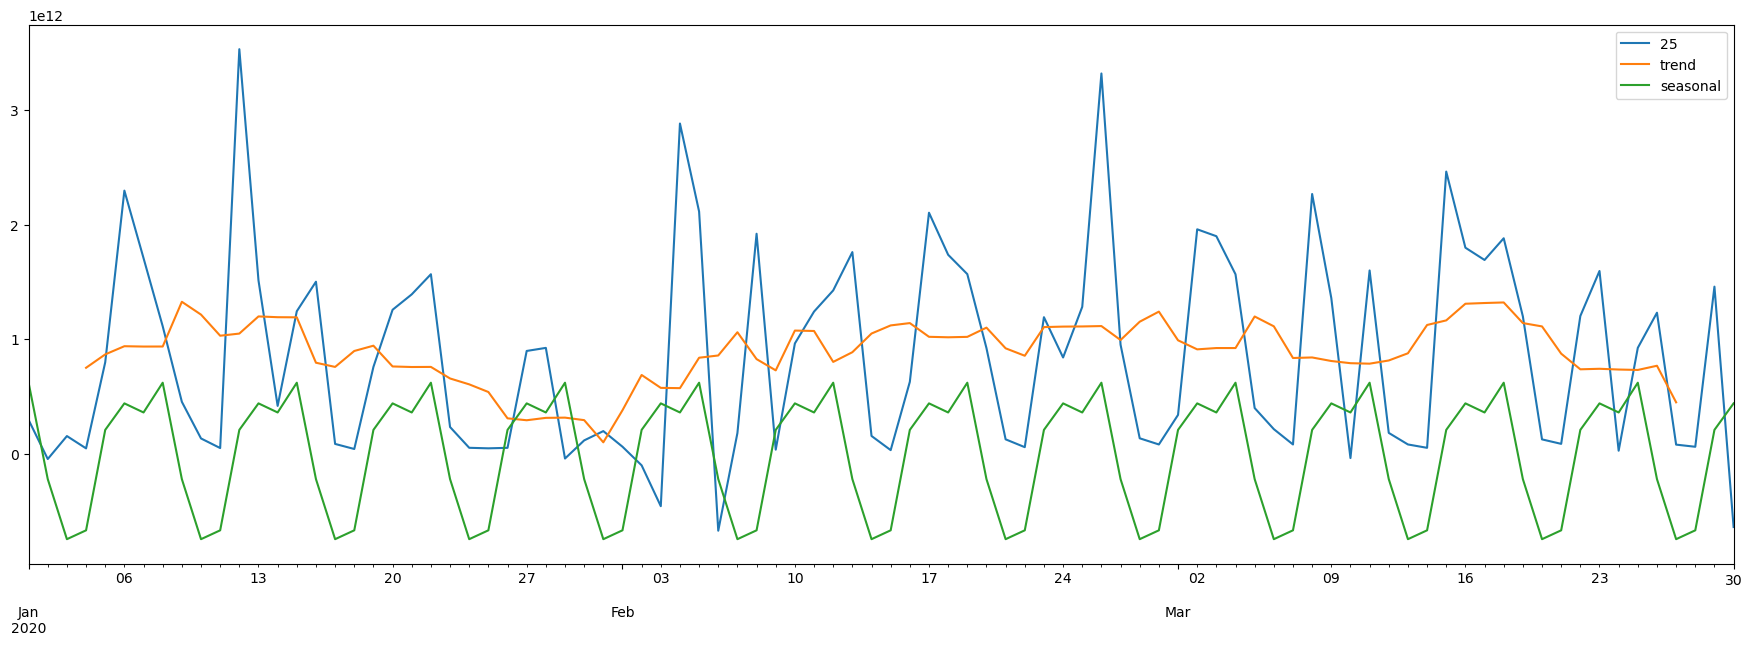

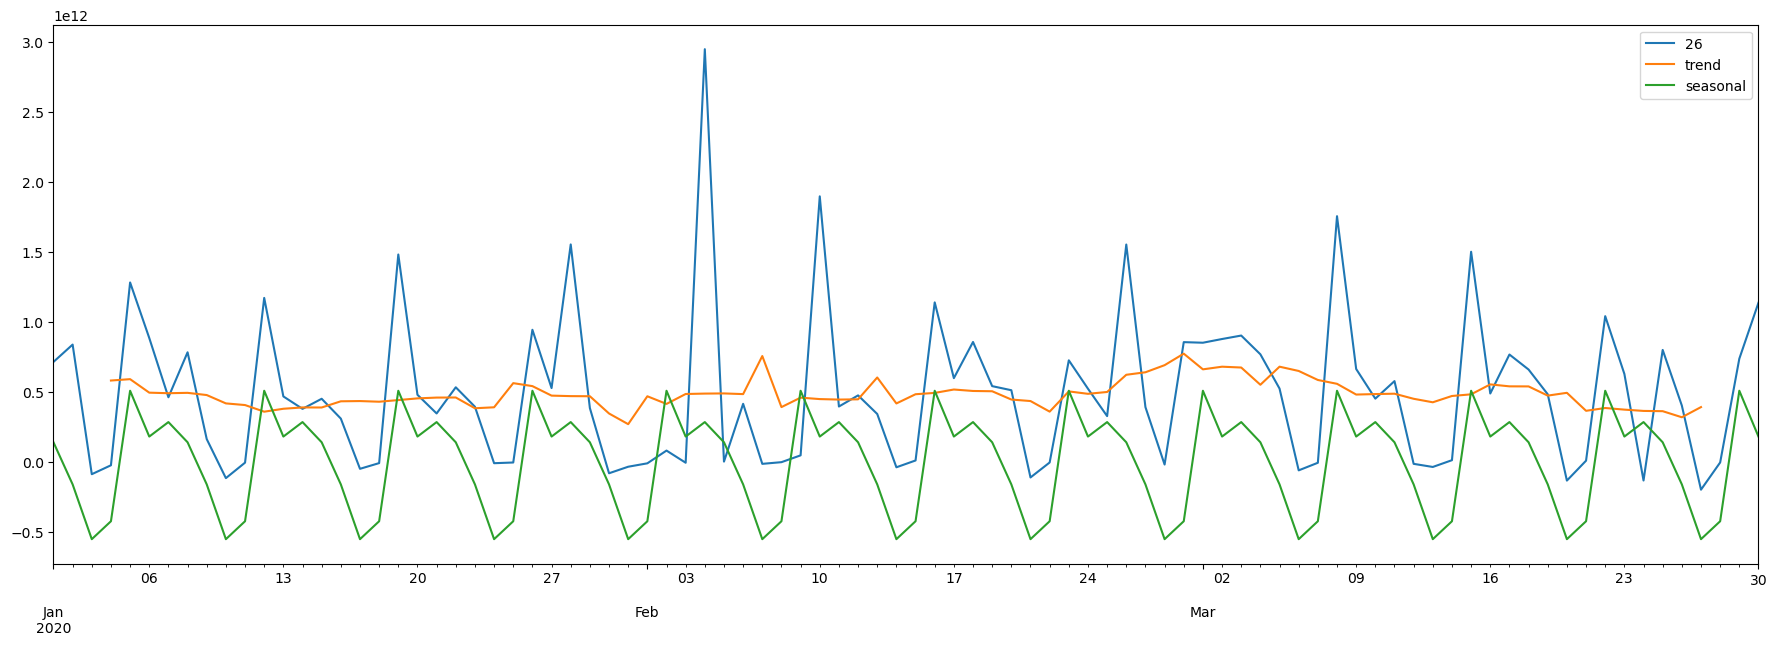

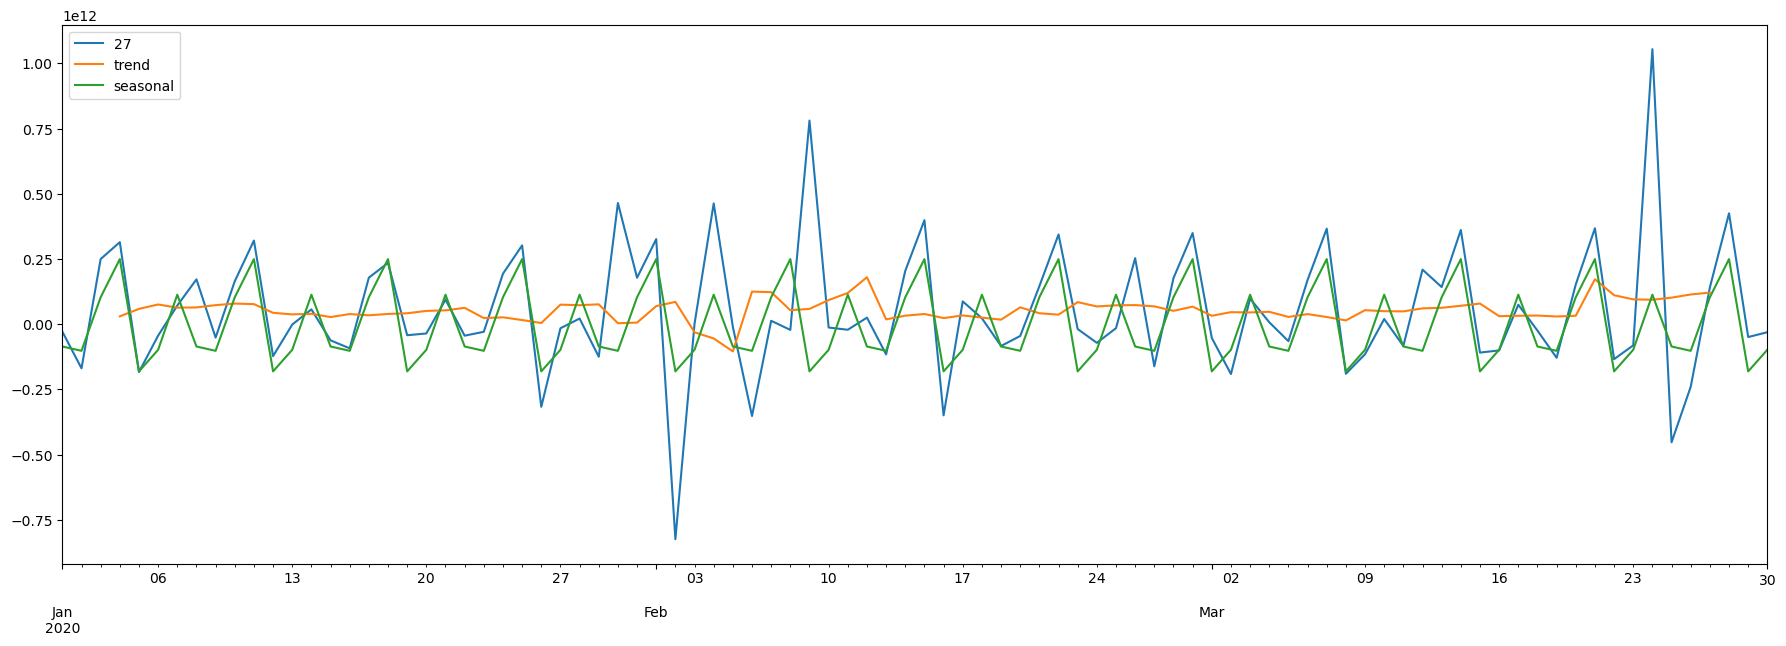

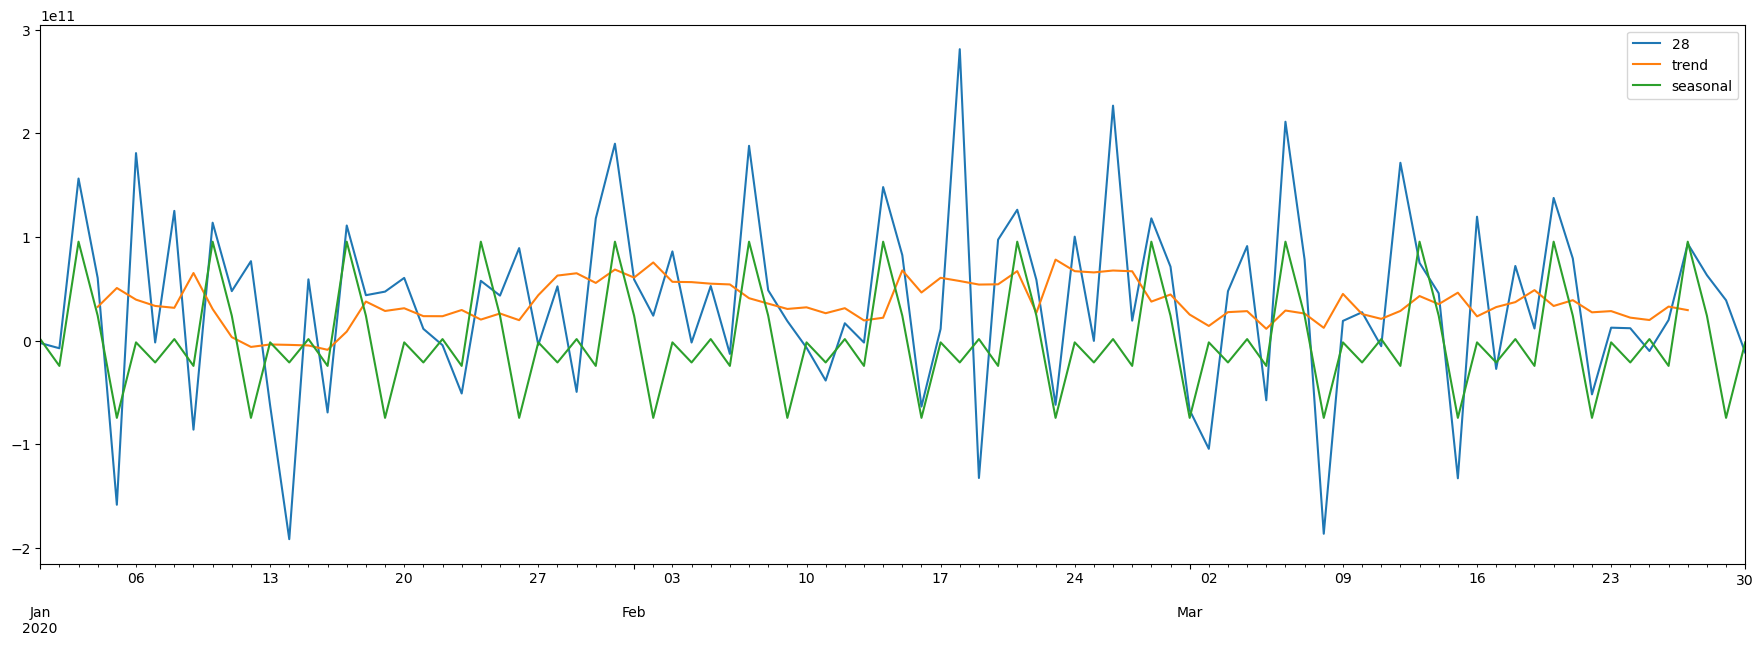

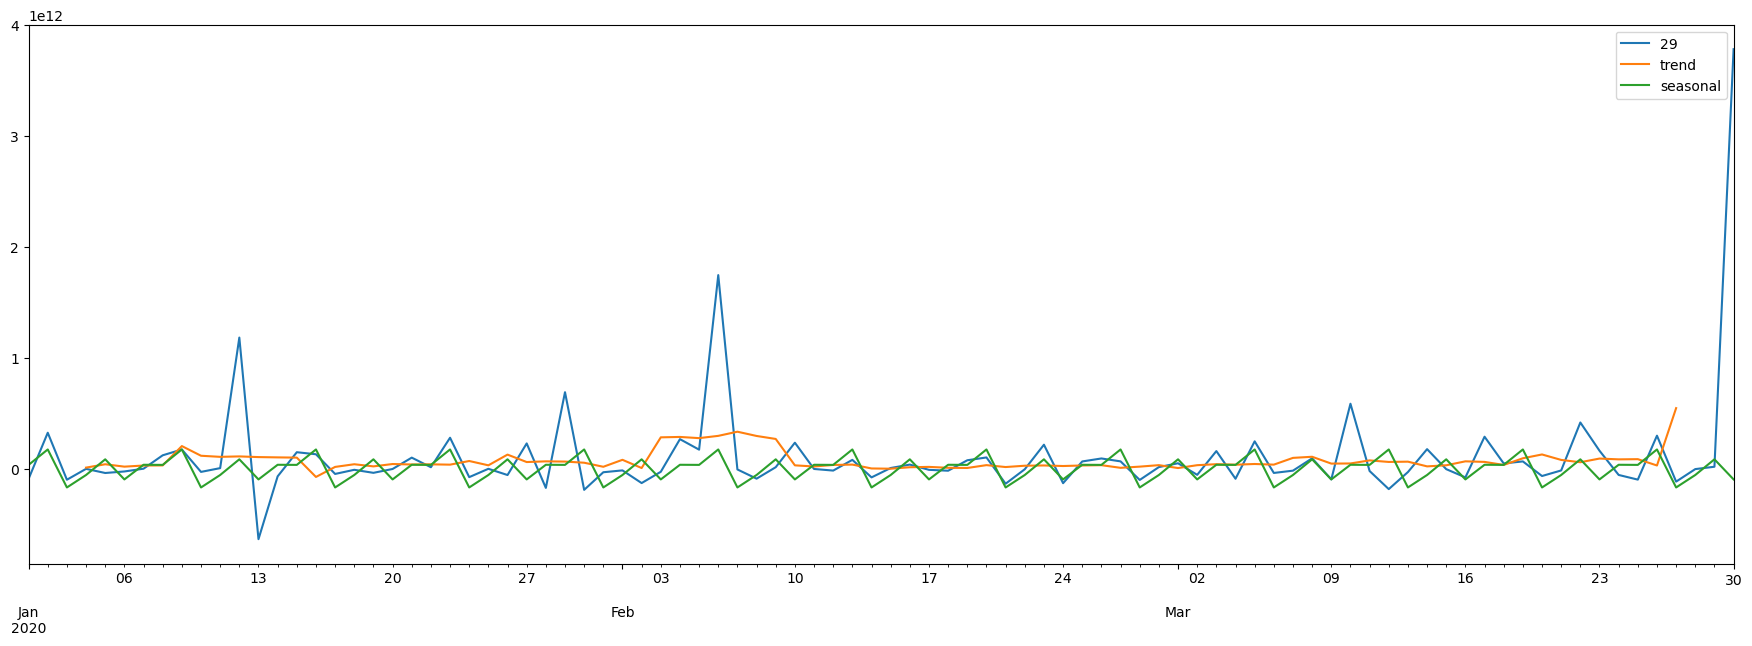

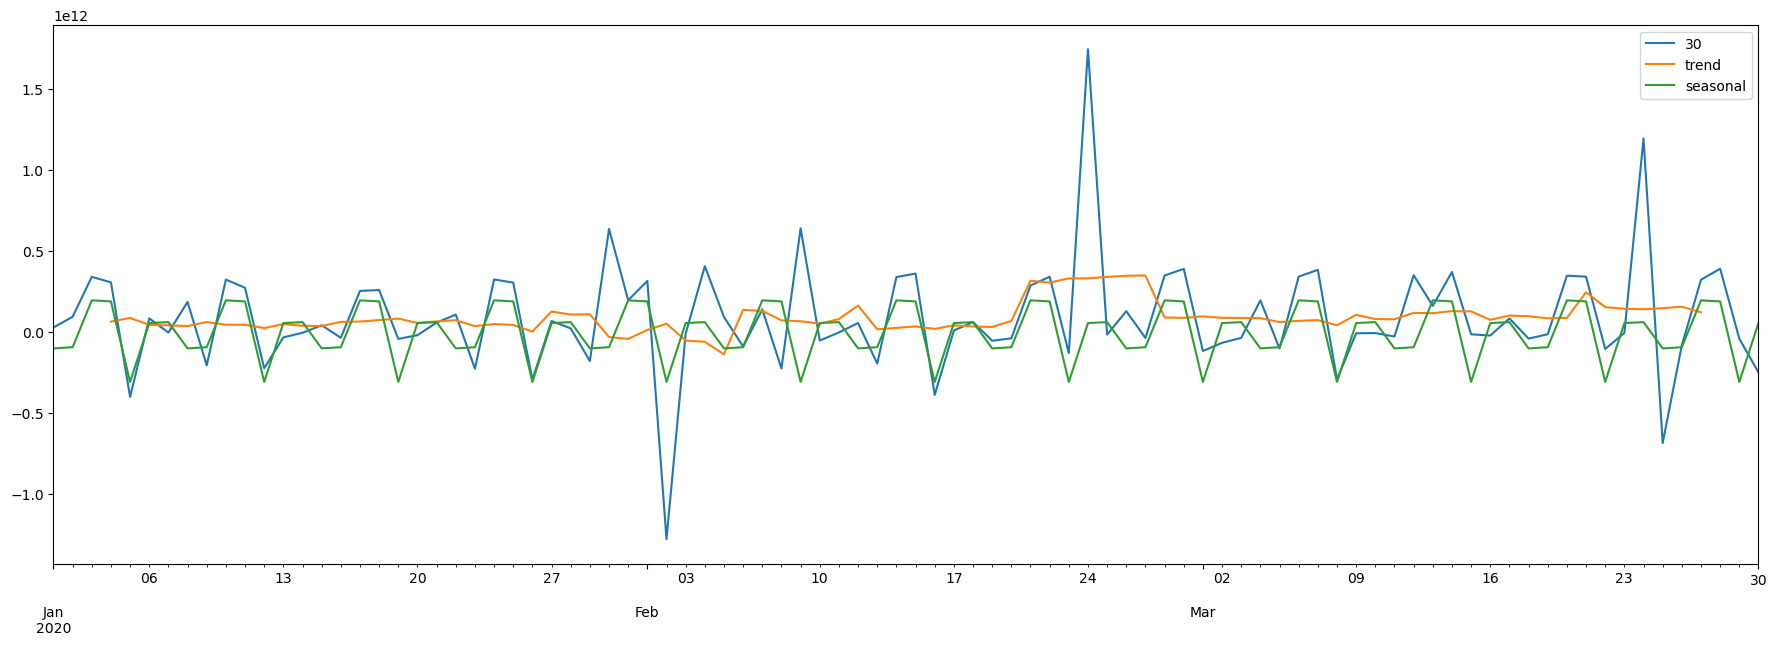

In [24]:
for i in range(20, 31):
    plt.figure().set_figwidth(35)
    decomposition = seasonal_decompose(temp_T[i])
    trend    = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
#     axis[i-20].plot(plot_x, temp_T[i].values, label='original')
#     axis[i-20].plot(plot_x, trend.values, label='trebd')
#     axis[i-20].plot(plot_x, seasonal.values, label='seasonal')
    temp_T[i].plot(figsize=[22, 7])
    trend.plot(figsize=[22, 7])
    seasonal.plot(figsize=[22, 7])
    plt.legend()
    plt.show()

In [153]:
X_features.head()

NameError: name 'X_features' is not defined

In [29]:
km = TimeSeriesKMeans(n_clusters=5, verbose=True, random_state=55)
# Keep only 50 time series
df_sc = TimeSeriesScalerMeanVariance().fit_transform(X)
# Make time series shorter
km.fit(df_sc)
clusters = km.predict(df_sc)

X_new['cluster'] = clusters 

57.896 --> 39.969 --> 38.530 --> 36.017 --> 35.148 --> 34.965 --> 34.923 --> 34.894 --> 34.879 --> 34.873 --> 34.871 --> 34.871 --> 34.871 --> 34.871 --> 34.871 --> 34.871 --> 34.871 --> 34.871 --> 34.871 --> 34.871 --> 


In [30]:
X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size=0.2)

In [246]:
X_train_season, X_test_season = season_df.loc[list(X_train.index)], season_df.loc[list(X_test.index)]
X_train_trend, X_test_trend = trend_df.loc[list(X_train.index)], trend_df.loc[list(X_test.index)]

In [34]:
X_train_season.head()

,seasonal_1,seasonal_2,seasonal_3,seasonal_4,seasonal_5,seasonal_6,seasonal_7,seasonal_8,seasonal_9,seasonal_10,...,seasonal_80,seasonal_81,seasonal_82,seasonal_83,seasonal_84,seasonal_85,seasonal_86,seasonal_87,seasonal_88,seasonal_89
19500,8.636172e+10,2.844175e+11,-3.762344e+11,-4.971347e+11,1.589359e+10,2.350447e+11,2.516515e+11,8.636172e+10,2.844175e+11,-3.762344e+11,...,-3.762344e+11,-4.971347e+11,1.589359e+10,2.350447e+11,2.516515e+11,8.636172e+10,2.844175e+11,-3.762344e+11,-4.971347e+11,1.589359e+10
16073,7.410595e+11,-2.672399e+11,-1.333867e+12,-1.166931e+12,6.951926e+11,7.297429e+11,6.020432e+11,7.410595e+11,-2.672399e+11,-1.333867e+12,...,-1.333867e+12,-1.166931e+12,6.951926e+11,7.297429e+11,6.020432e+11,7.410595e+11,-2.672399e+11,-1.333867e+12,-1.166931e+12,6.951926e+11
9820,6.692317e+11,-2.357322e+11,-9.294166e+11,-7.550037e+11,4.331352e+11,4.601419e+11,3.576438e+11,6.692317e+11,-2.357322e+11,-9.294166e+11,...,-9.294166e+11,-7.550037e+11,4.331352e+11,4.601419e+11,3.576438e+11,6.692317e+11,-2.357322e+11,-9.294166e+11,-7.550037e+11,4.331352e+11
15159,4.732684e+09,-2.862176e+10,1.042857e+11,2.942717e+10,7.804200e+09,-9.438837e+10,-2.323961e+10,4.732684e+09,-2.862176e+10,1.042857e+11,...,1.042857e+11,2.942717e+10,7.804200e+09,-9.438837e+10,-2.323961e+10,4.732684e+09,-2.862176e+10,1.042857e+11,2.942717e+10,7.804200e+09
10749,2.688890e+10,-8.114457e+10,-1.969158e+10,-1.502372e+10,2.614147e+09,9.343729e+10,-7.080464e+09,2.688890e+10,-8.114457e+10,-1.969158e+10,...,-1.969158e+10,-1.502372e+10,2.614147e+09,9.343729e+10,-7.080464e+09,2.688890e+10,-8.114457e+10,-1.969158e+10,-1.502372e+10,2.614147e+09


## Обучим модель

In [154]:
from catboost import CatBoostRegressor

In [247]:
class RmseObjective(object):
    def calc_ders_range(self, approxes, targets, weights, gamma=200):
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)

        result = []
        for index in range(len(targets)):
            if targets[index] > approxes[index]:
                der1 = targets[index] - approxes[index]
            else:
                der1 = (targets[index] - approxes[index]) * gamma
            der2 = -1

            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]

            result.append((der1, der2))
        return result

In [248]:
class RmseMetric(object):
    def get_final_error(self, error, weight):
        return np.sqrt(error / (weight + 1e-38))

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        error_sum = 0.0
        weight_sum = 0.0

        for i in range(len(approx)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            error_sum += w * ((approx[i] - target[i])**2)

        return error_sum, weight_sum

In [289]:
# %%time
# models_base_zoo = []
# models_seasoning_zoo = []
# models_trend_zoo = []
# for params in [(4, 24), (8, 112), (2, 666), (6, 12321)]:
#     model_base = CatBoostRegressor(n_estimators=500, depth=params[0], random_seed=params[1], loss_function=RmseObjective(), eval_metric=RmseMetric())
#     model_trend = CatBoostRegressor(n_estimators=1000, depth=params[0], random_seed=params[1], loss_function=RmseObjective(), eval_metric=RmseMetric())
#     model_seasoning = CatBoostRegressor(n_estimators=500, depth=params[0], random_seed=params[1], loss_function=RmseObjective(), eval_metric=RmseMetric())
#     model_base.fit(rnn_features_train, Y_train)
#     model_trend.fit(X_train_trend, Y_train)
#     model_seasoning.fit(X_train_season, Y_train)
#     models_base_zoo.append(model_base)
#     models_seasoning_zoo.append(model_seasoning)
#     models_trend_zoo.append(model_trend)
    
model_predictions = []
for cb_base, cb_seasoning, cb_trend in zip(models_base_zoo, models_seasoning_zoo, models_trend_zoo):
    pred_base = cb_base.predict(rnn_features_test)
    pred_seasoning = cb_seasoning.predict(X_test_season)
    pred_trend = cb_trend.predict(X_test_trend)
    model_predictions.append((pred_base + pred_seasoning + pred_trend) / 3)
final_pred = sum(model_predictions) / len(model_predictions)

In [285]:
1

1

In [128]:
pred_base = model_base.predict(X_test)
# pred_trend = model_trend.predict(X_test_trend)
pred_seasoning = model_seasoning.predict(X_test_season)
final_pred = (pred_base + pred_seasoning) / 2

In [288]:
pred_base = model_base.predict(X_test)

In [290]:
metric(Y_test.tolist(), final_pred)

-13419

-14388

In [294]:
# Попробуем уменьшить предсказания, чтобы оптимизировать ассиметричную метрику
metric(Y_test.tolist(), [1.05  * x for x in final_pred])

-11431

## Сделаем предсказание

In [295]:
df_test = pd.read_csv('/kaggle/input/tochka/hackaton-tochka-2023/data/test.csv')

In [304]:
X_pred = df_test[[f'day {x}' for x in range(2, 91)]]

In [305]:
X_pred.columns = [f'day {x}' for x in range(1, 90)]

In [298]:
X_pred

,day 1,day 2,day 3,day 4,day 5,day 6,day 7,day 8,day 9,day 10,...,day 80,day 81,day 82,day 83,day 84,day 85,day 86,day 87,day 88,day 89
0,-27272300199,-27800332399,-16689257367,49452188382,-164672959015,68718333232,86268084236,-70506694486,-3477632403,-3799943105,...,-4582343562,326950303668,-3436387694,122140991641,151334162458,-68091565991,-16819147743,-15358116160,290052350358,32601073101
1,846030141571,-33152897348,59895470611,1418062668812,805683303608,503783716867,749931146239,499672747741,-46082937966,80196643036,...,249951801872,559119607149,966273032724,1045197562471,862064304369,505563334665,107226417884,273971583544,572295659253,1144571996962
2,-25048867838,-19254930569,-18384090574,124331619653,20290831215,27134052336,76511879742,-90024242485,-2359931294,-9458580898,...,-86559116,261408486882,299664664434,90846538293,-102949211728,-43191548770,-10056078392,-15665662730,293353666747,43807377752
3,82250786704,254361079368,54791107464,-206893107189,42148395027,65927292720,52898180437,-106045846642,200099915902,114131582628,...,123343719019,-39094916553,-15529507716,89629754250,51896943059,49752183476,224010809923,104368667196,-34583919320,-13055636594
4,285183216995,36354487997,23489067684,-208696112872,-216436150668,-155293807,111909112423,290765974833,86170986247,47980493892,...,200226907407,-434528402333,-12773811475,89816101594,-7208702166,608588948616,219352905521,200554704652,-848832033231,80965092142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-11353131271,668006319976,523765913085,-958178654519,-8099416734,295981937322,94722328040,27491845525,556180488526,564654985454,...,726060623930,-823099344628,-207476189074,138630750737,-4302963459,351214543922,755514923963,693573209816,-509102519724,-29412926348
9996,61937152242,-11881152865,-31054828388,63552409055,-13759416848,-12287755799,174144088106,101578950830,-20183560456,-22821507400,...,-17454974969,-75886145853,-18029503498,78959046840,-17699508750,439599944598,-13511332571,-15065680719,-53097677986,126030939348
9997,1164706729770,-5388368944,-9682237569,1050388657626,797376882704,637246804134,858932835424,616638813606,-15770107065,-4079251438,...,2085786161,342505850778,868747220767,1128900432276,1042689209987,971092470036,19423122575,423489943,543094146794,1340379738298
9998,-252798479850,263429371031,469567010004,-27498352183,-14573794921,64452229427,-866741041,-138722364494,132866762121,425273162463,...,554668267149,-185590545513,-149047959508,47784416389,38166016181,-160884089872,271857393742,543702522048,-234298144677,153529239668


In [299]:
raw_scaled = TimeSeriesScalerMeanVariance().fit_transform([X_pred])
for i in range(2, 91):
    X_pred[f'day {i}'] = raw_scaled[:, :, i-2][0]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [300]:
X_pred

,day 1,day 2,day 3,day 4,day 5,day 6,day 7,day 8,day 9,day 10,...,day 81,day 82,day 83,day 84,day 85,day 86,day 87,day 88,day 89,day 90
0,-27272300199,-0.422450,-0.696592,-0.633149,-0.638673,-0.841480,-0.753463,-0.794467,-0.735500,-0.574119,...,-0.749122,-0.183939,-0.702831,-0.637513,-0.360785,-0.826995,-0.772222,-0.797913,0.020411,-0.551100
1,846030141571,0.504802,-0.721872,-0.255946,0.827404,0.310131,-0.328183,0.010711,0.581268,-0.813011,...,0.258352,0.090055,0.224798,0.453387,0.529883,0.161848,-0.257168,0.349208,0.522948,0.282947
2,-25048867838,-0.420089,-0.656233,-0.641496,-0.558461,-0.621967,-0.794112,-0.806304,-0.780573,-0.567852,...,-0.731328,-0.261288,-0.412883,-0.674498,-0.679447,-0.784074,-0.744141,-0.799132,0.026289,-0.542695
3,82250786704,-0.306161,0.636044,-0.281086,-0.913274,-0.596026,-0.756191,-0.834953,-0.817573,0.567360,...,-0.242777,-0.615926,-0.714399,-0.675936,-0.485398,-0.623861,0.227736,-0.323226,-0.557606,-0.585345
4,285183216995,-0.090692,-0.393592,-0.435258,-0.915205,-0.902912,-0.820787,-0.763359,0.098820,-0.071451,...,0.061536,-1.082596,-0.711763,-0.675716,-0.559467,0.339440,0.208396,0.058128,-2.007382,-0.514824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-11353131271,-0.405547,2.589673,2.028755,-1.718062,-0.655660,-0.531311,-0.784210,-0.509183,2.563937,...,2.142844,-1.541167,-0.898016,-0.618025,-0.555826,-0.104212,2.434611,2.012826,-1.402491,-0.597614
9996,61937152242,-0.327729,-0.621407,-0.703903,-0.623568,-0.662377,-0.832647,-0.687853,-0.338087,-0.667791,...,-0.800074,-0.659345,-0.716791,-0.688547,-0.572614,0.048143,-0.758487,-0.796753,-0.590570,-0.481022
9997,1164706729770,0.843166,-0.590742,-0.598637,0.433546,0.300273,-0.197722,0.142956,0.851388,-0.643044,...,-0.722729,-0.165581,0.131505,0.552310,0.756237,0.964309,-0.621739,-0.735343,0.470954,0.429815
9998,-252798479850,-0.661908,0.678873,1.761810,-0.721103,-0.663344,-0.757633,-0.900182,-0.893036,0.190377,...,1.464454,-0.788812,-0.842124,-0.725391,-0.502605,-0.986947,0.426401,1.418625,-0.913199,-0.460396


In [301]:
torch.Tensor(X_pred.iloc[1]).unsqueeze(0).shape

torch.Size([1, 90])

In [302]:
out_hist = []
for i in range(10000):
    temp_data = torch.Tensor(X_pred.iloc[i, 1:]).unsqueeze(0).to(device)
    output = model(temp_data)[-1].cpu().detach().numpy()
    out_hist.append(output)
out_hist = np.array(out_hist)

In [303]:
new_hist = [0] * 10000
for i in range(len(out_hist)):
    new_hist[i] = out_hist[i].squeeze()[:, -1]
new_hist = np.array(new_hist)

In [306]:
dates = np.array('2020-01-01', dtype=np.datetime64) + np.arange(89)
X_pred_T = X_pred.T
X_pred_T.index = dates
X_pred_T.head()

season_df = pd.DataFrame(index=[f'seasonal_{i}' for i in range(1, 90)]).T
trend_df = pd.DataFrame(index=[f'trend_{i}' for i in range(1, 90)]).T
residual_df = pd.DataFrame(index=[f'residual_{i}' for i in range(1, 90)]).T
for i in range(10000):
    decomposition = seasonal_decompose(X_pred_T[i])
    trend    = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    season_df.loc[len(season_df)] = list(seasonal.values)
    trend_df.loc[len(trend_df)] = list(trend.values)
    residual.loc[len(residual_df)] = list(residual.values)

In [144]:
df_ts = pd.DataFrame()
for i, ts in enumerate(X_pred.values):
    data = [[x, i] for x in ts]
    df_ts = df_ts.append(data, ignore_index=True)
df_ts.columns = ['value', 'id']
X_features = extract_features(df_ts, column_id='id', impute_function=impute, default_fc_parameters=settings_time)

Feature Extraction: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


In [145]:
clusters = km.predict(X_pred)
X_pred['cluster'] = clusters 
X_pred = pd.concat([X_pred, X_features], axis=1)

/opt/conda/lib/python3.7/site-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 10000 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [267]:
X_pred.columns

Index(['day 1', 'day 2', 'day 3', 'day 4', 'day 5', 'day 6', 'day 7', 'day 8',
       'day 9', 'day 10', 'day 11', 'day 12', 'day 13', 'day 14', 'day 15',
       'day 16', 'day 17', 'day 18', 'day 19', 'day 20', 'day 21', 'day 22',
       'day 23', 'day 24', 'day 25', 'day 26', 'day 27', 'day 28', 'day 29',
       'day 30', 'day 31', 'day 32', 'day 33', 'day 34', 'day 35', 'day 36',
       'day 37', 'day 38', 'day 39', 'day 40', 'day 41', 'day 42', 'day 43',
       'day 44', 'day 45', 'day 46', 'day 47', 'day 48', 'day 49', 'day 50',
       'day 51', 'day 52', 'day 53', 'day 54', 'day 55', 'day 56', 'day 57',
       'day 58', 'day 59', 'day 60', 'day 61', 'day 62', 'day 63', 'day 64',
       'day 65', 'day 66', 'day 67', 'day 68', 'day 69', 'day 70', 'day 71',
       'day 72', 'day 73', 'day 74', 'day 75', 'day 76', 'day 77', 'day 78',
       'day 79', 'day 80', 'day 81', 'day 82', 'day 83', 'day 84', 'day 85',
       'day 86', 'day 87', 'day 88', 'day 89'],
      dtype='object')

In [268]:
out_hist.shape

(10000, 1, 89, 64)

In [307]:
model_predictions = []
for cb_base, cb_seasoning, cb_trend in zip(models_base_zoo, models_seasoning_zoo, models_trend_zoo):
    pred_base = cb_base.predict(new_hist)
    pred_seasoning = cb_seasoning.predict(season_df)
    pred_trend = cb_trend.predict(trend_df)
    model_predictions.append((pred_base + pred_seasoning + pred_trend)/ 3)
final_pred = sum(model_predictions) / len(model_predictions)

In [110]:
pred_base = model_base.predict(X_pred)
# pred_trend = model_trend.predict(trend_df)
pred_seasoning = model_seasoning.predict(season_df)
final_pred = (pred_base + pred_seasoning) / 2
# pred = model.predict(X_pred)

In [309]:
df_test['day 91'] = final_pred

In [310]:
df_test.head()

,id,day 1,day 2,day 3,day 4,day 5,day 6,day 7,day 8,day 9,...,day 82,day 83,day 84,day 85,day 86,day 87,day 88,day 89,day 90,day 91
0,7557384322498,230954240295,-27272300199,-27800332399,-16689257367,49452188382,-164672959015,68718333232,86268084236,-70506694486,...,326950303668,-3436387694,122140991641,151334162458,-68091565991,-16819147743,-15358116160,290052350358,32601073101,-2.351756e+11
1,5542820662236,1413991058023,846030141571,-33152897348,59895470611,1418062668812,805683303608,503783716867,749931146239,499672747741,...,559119607149,966273032724,1045197562471,862064304369,505563334665,107226417884,273971583544,572295659253,1144571996962,-9.890416e+11
2,3487586486086,-17896487455,-25048867838,-19254930569,-18384090574,124331619653,20290831215,27134052336,76511879742,-90024242485,...,261408486882,299664664434,90846538293,-102949211728,-43191548770,-10056078392,-15665662730,293353666747,43807377752,-8.767507e+11
3,7642553352884,-10377795586,82250786704,254361079368,54791107464,-206893107189,42148395027,65927292720,52898180437,-106045846642,...,-39094916553,-15529507716,89629754250,51896943059,49752183476,224010809923,104368667196,-34583919320,-13055636594,-7.296493e+11
4,4173983498448,-423790789653,285183216995,36354487997,23489067684,-208696112872,-216436150668,-155293807,111909112423,290765974833,...,-434528402333,-12773811475,89816101594,-7208702166,608588948616,219352905521,200554704652,-848832033231,80965092142,-2.049692e+12


In [311]:
df_test['day 91'] = df_test['day 91'].round()

In [312]:
df_test['day 91'].iloc[0]

-235175590185.0

In [316]:
df_test[['id', 'day 91']].to_csv('/kaggle/working/samplesubmission4.csv', index=False)

In [317]:
import os
os.listdir('/kaggle/working/')

['.virtual_documents',
 'samplesubmission3.csv',
 'catboost_info',
 '__notebook_source__.ipynb',
 'samplesubmission2.csv',
 'samplesubmission4.csv']

In [318]:
from IPython.display import FileLink
FileLink(r'/kaggle/working/samplesubmission4.csv')

/kaggle/working/samplesubmission4.csv

<a href="/kaggle/working/samplesubmission3.csv"> Download File </a>